# Output Analysis

This file is used to analyze output.

In [1]:
import os

if not os.getcwd().endswith('pypsa-eur-climact'):
    %cd ../..
%pwd

/Users/climact/pypsa/pypsa-eur-climact


'/Users/climact/pypsa/pypsa-eur-climact'

In [2]:
from pathlib import Path
import pypsa
import pandas as pd
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (25, 6)
pd.set_option("display.width", 1000)

n_path = Path("analysis", "CANEurope", "results")
n_name = "elec_s180_37m_lcopt__3H_"

In [3]:
def graph_display(n: dict[int, pd.DataFrame], kind: str = "plot", title: str = "", unit: str = ""):
    df = []
    for k, ni in n.items():
        df.append(ni.sum(axis=1).rename(f"{k}"))
    df = pd.concat(df, axis=1)
    if kind == "plot":
        df.sort_index().fillna(method="ffill").plot(title=title, ylabel=unit)
    elif kind == "bar":
        df.plot.bar(title=title, ylabel=unit)
    elif kind == "hist":
        df.plot.hist(title=title, xlabel=unit, alpha=0.8)
    else:
        raise RuntimeError

def get_state_of_charge_t(n, carrier):
    df = n.storage_units_t.state_of_charge.T.reset_index()
    df = df.merge(n.storage_units.reset_index()[["carrier", "StorageUnit"]], on="StorageUnit")
    df = df.groupby(by="carrier").sum()
    del df["StorageUnit"]
    return df.T[[carrier]]

In [4]:
years = [2030, 2035, 2040]
n = {}
for y in years:
    n[f"{y}"] = pypsa.Network(Path(n_path, "postnetworks", n_name + f"{y}.nc"))

Index(['DE0 0 urban central solid biomass CHP-2005', 'GB4 0 urban central solid biomass CHP-2005', 'CH0 0 urban central solid biomass CHP-2010', 'CZ0 0 urban central solid biomass CHP-2010', 'DE0 0 urban central solid biomass CHP-2010', 'FR0 0 urban central solid biomass CHP-2010', 'GB4 0 urban central solid biomass CHP-2010', 'CH0 0 urban central solid biomass CHP-2015', 'DE0 0 urban central solid biomass CHP-2015', 'FR0 0 urban central solid biomass CHP-2015', 'GB4 0 urban central solid biomass CHP-2015', 'GB5 0 urban central solid biomass CHP-2015', 'DE0 0 urban central solid biomass CHP-2020', 'FR0 0 urban central solid biomass CHP-2020', 'GB4 0 urban central solid biomass CHP-2020'], dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s180_37m_lcopt__3H_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Index(['CH0 0 urban central solid biomass CHP-2010', 'CZ0 0 urban central solid biomass CHP-2010', 'DE0 0 urban ce

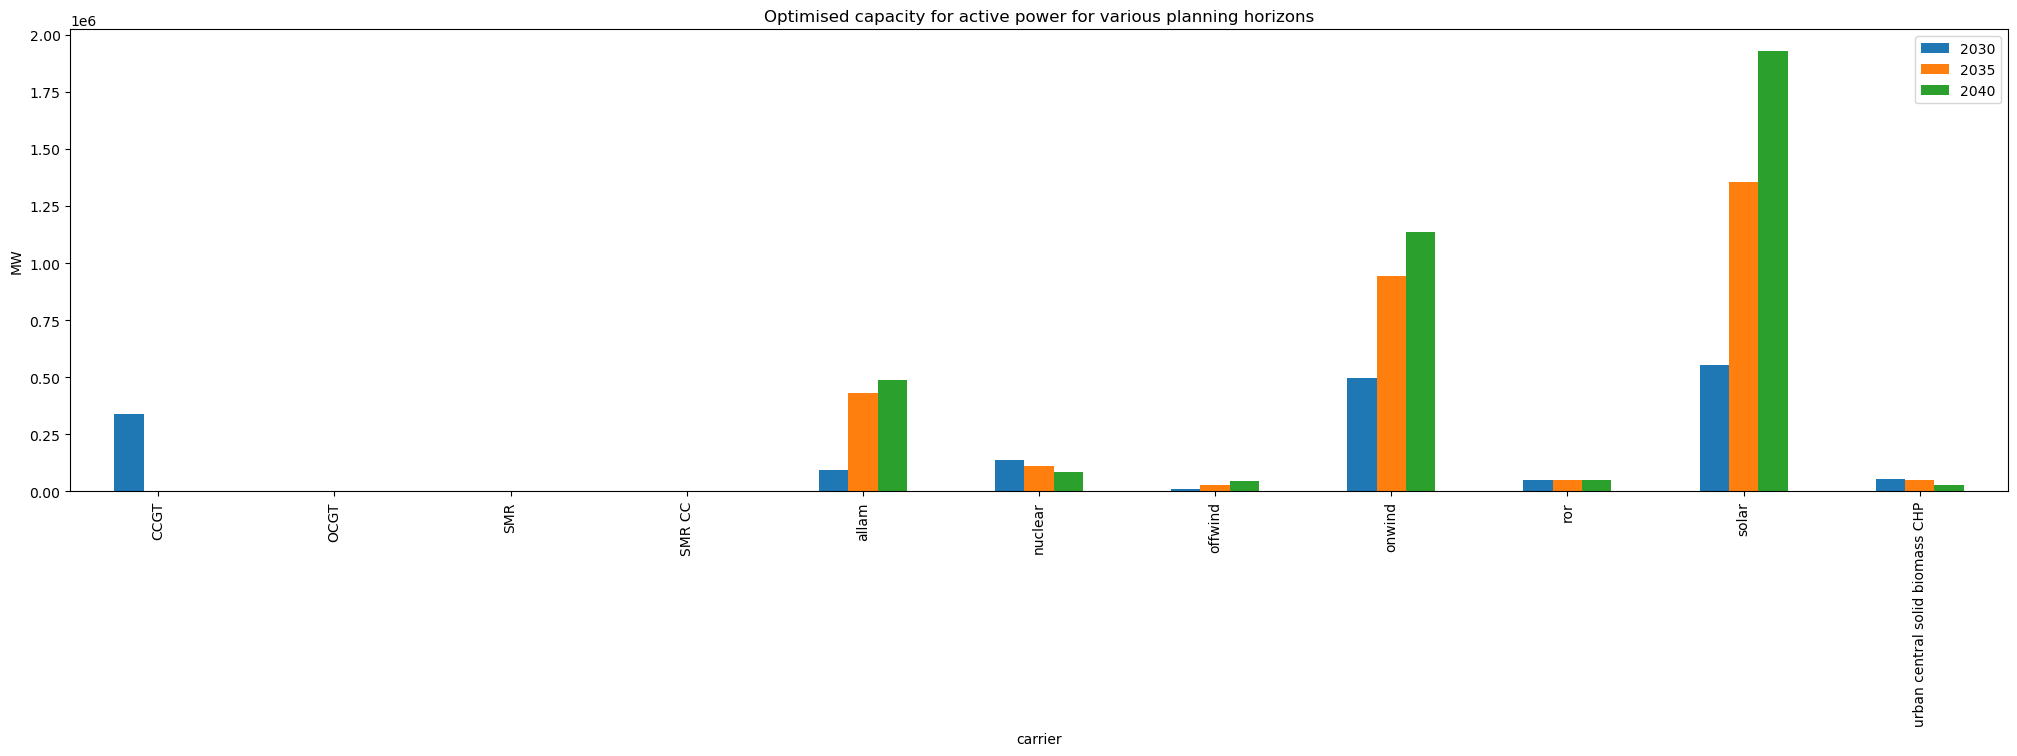

In [13]:
var = "p_nom_opt"
storage_exclude = ["H2 Electrolysis", "H2 Fuel Cell", "battery charger", "battery discharger", "home battery charger", "home battery discharger", "Haber-Bosch", "Sabatier", "ammonia cracker", "helmeth"]
generators_carrier_exclude = storage_exclude + ["gas", "coal", "lignite", "uranium", "oil", "DC", "gas pipeline", "gas pipeline new", "CO2 pipeline", "H2 pipeline", "H2 pipeline retrofitted", "electricity distribution grid"]
renamer = {"offwind-dc": "offwind", "offwind-ac": "offwind", "solar rooftop": "solar"}

n_links = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[~n_y.index.isin(generators_carrier_exclude)]
    n_links[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]] for k, ni in n_links.items()}, kind="bar", title="Optimised capacity for active power for various planning horizons", unit="MW")

Transmission network capacities for AC (brown) and DC (green) for 2030


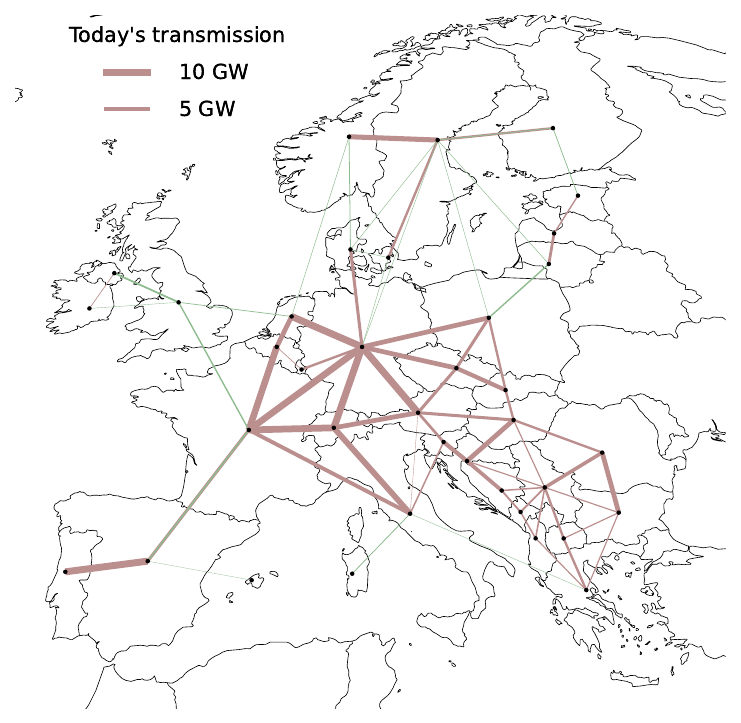

Transmission network capacities for AC (brown) and DC (green) for 2035


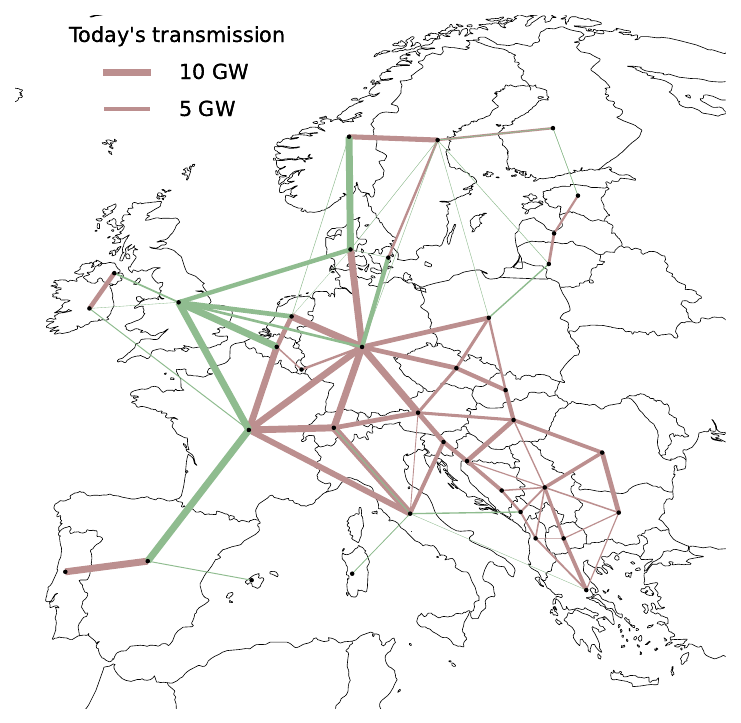

Transmission network capacities for AC (brown) and DC (green) for 2040


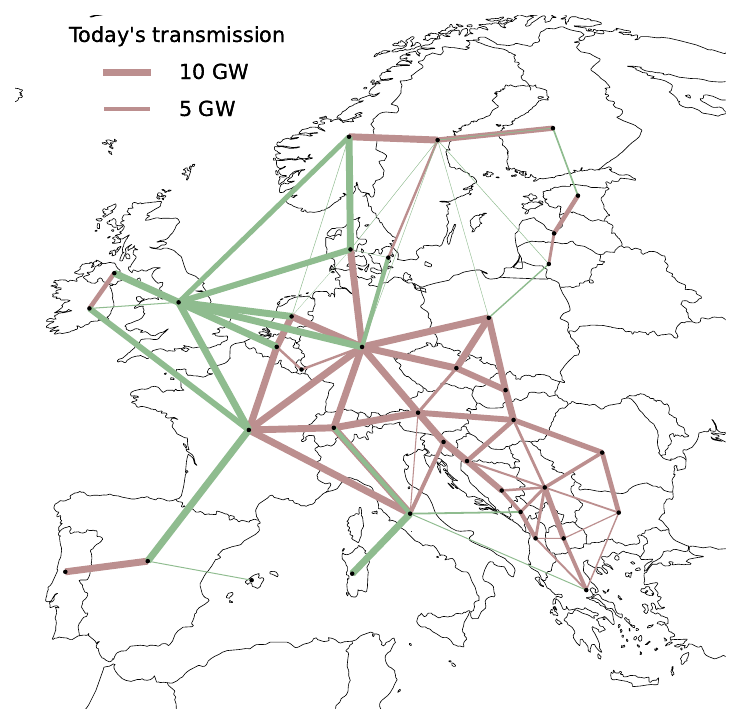

In [9]:
from IPython.display import Image

for y in years:
    filename = n_name + f"{y}-today"
    path = Path(n_path, "maps")
    file_pdf = Path(path, filename + ".pdf")
    file_png = Path(path, filename)
    ! pdftoppm {file_pdf} {file_png} -png
    print(f"Transmission network capacities for AC (brown) and DC (green) for {y}")
    display(Image(str(file_png) + "-1.png"))

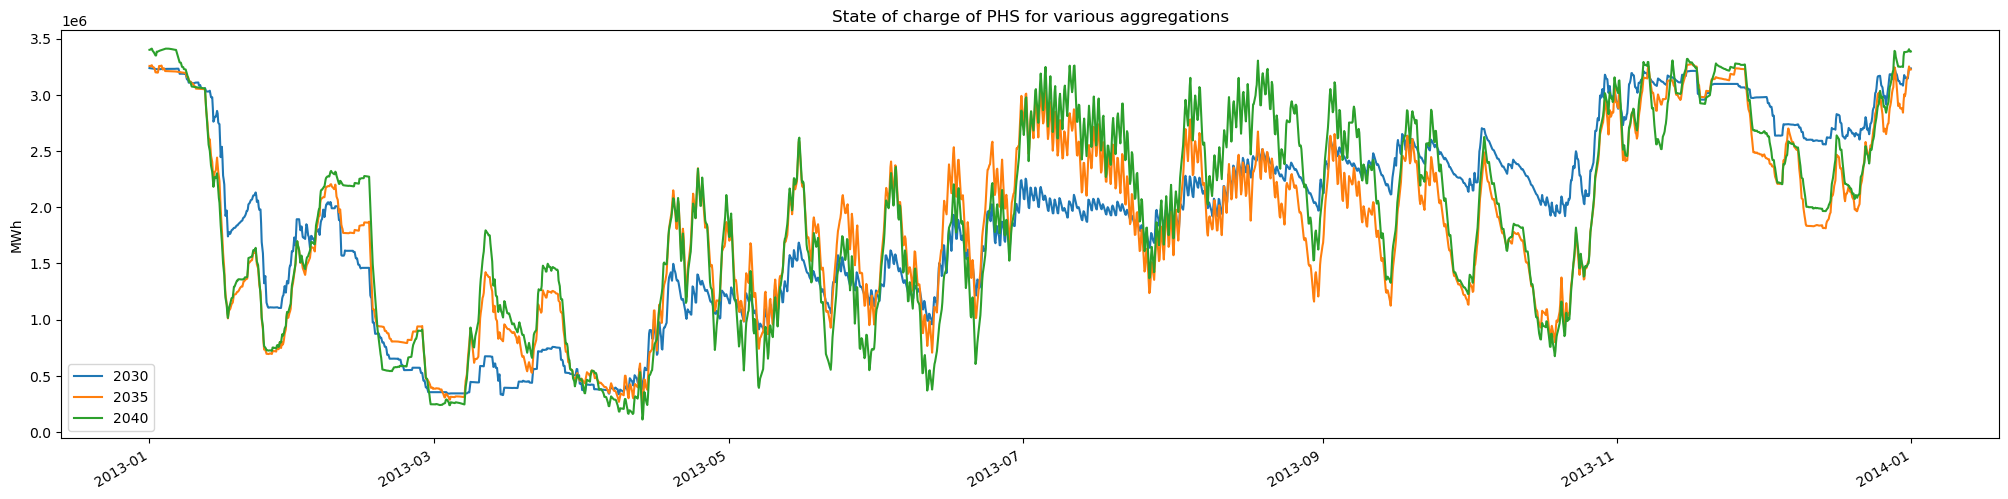

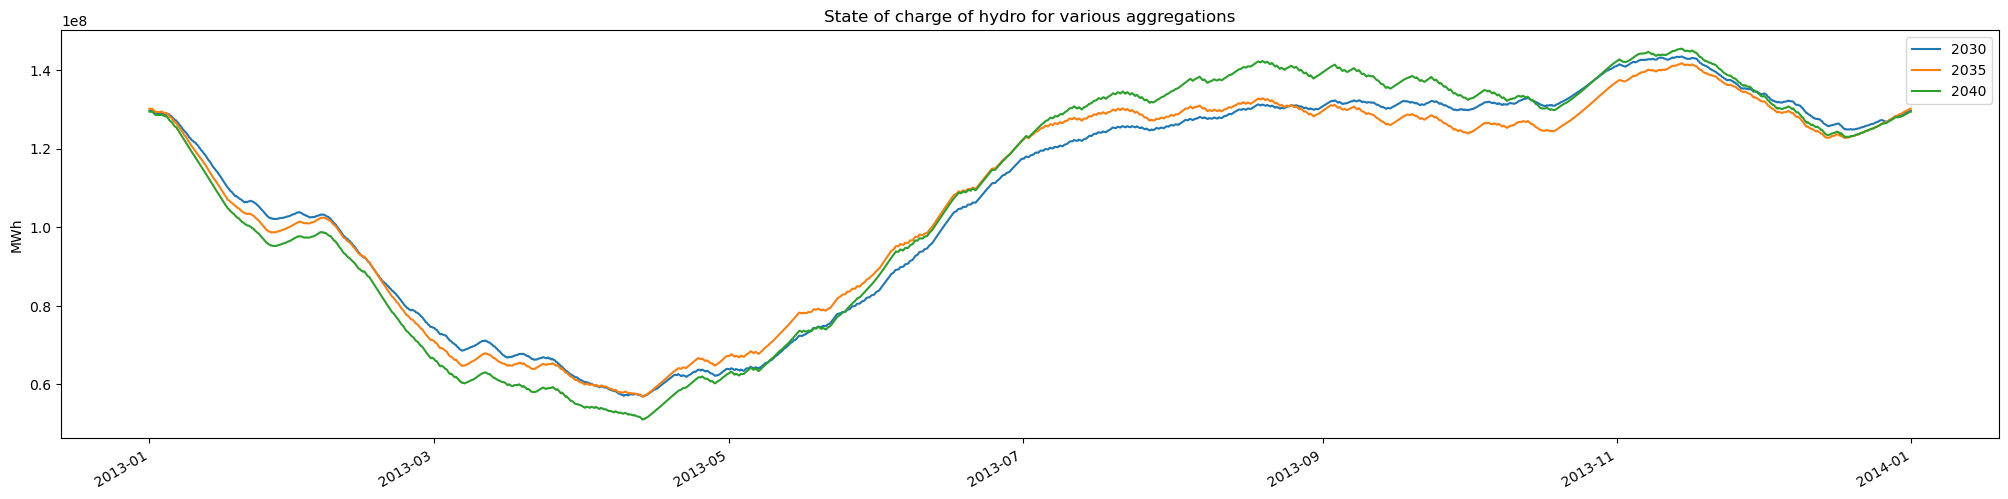

In [12]:
for carrier in ["PHS", "hydro"]:
    graph_display({k: get_state_of_charge_t(ni, carrier) for k, ni in n.items()}, title=f"State of charge of {carrier} for various aggregations", unit="MWh")

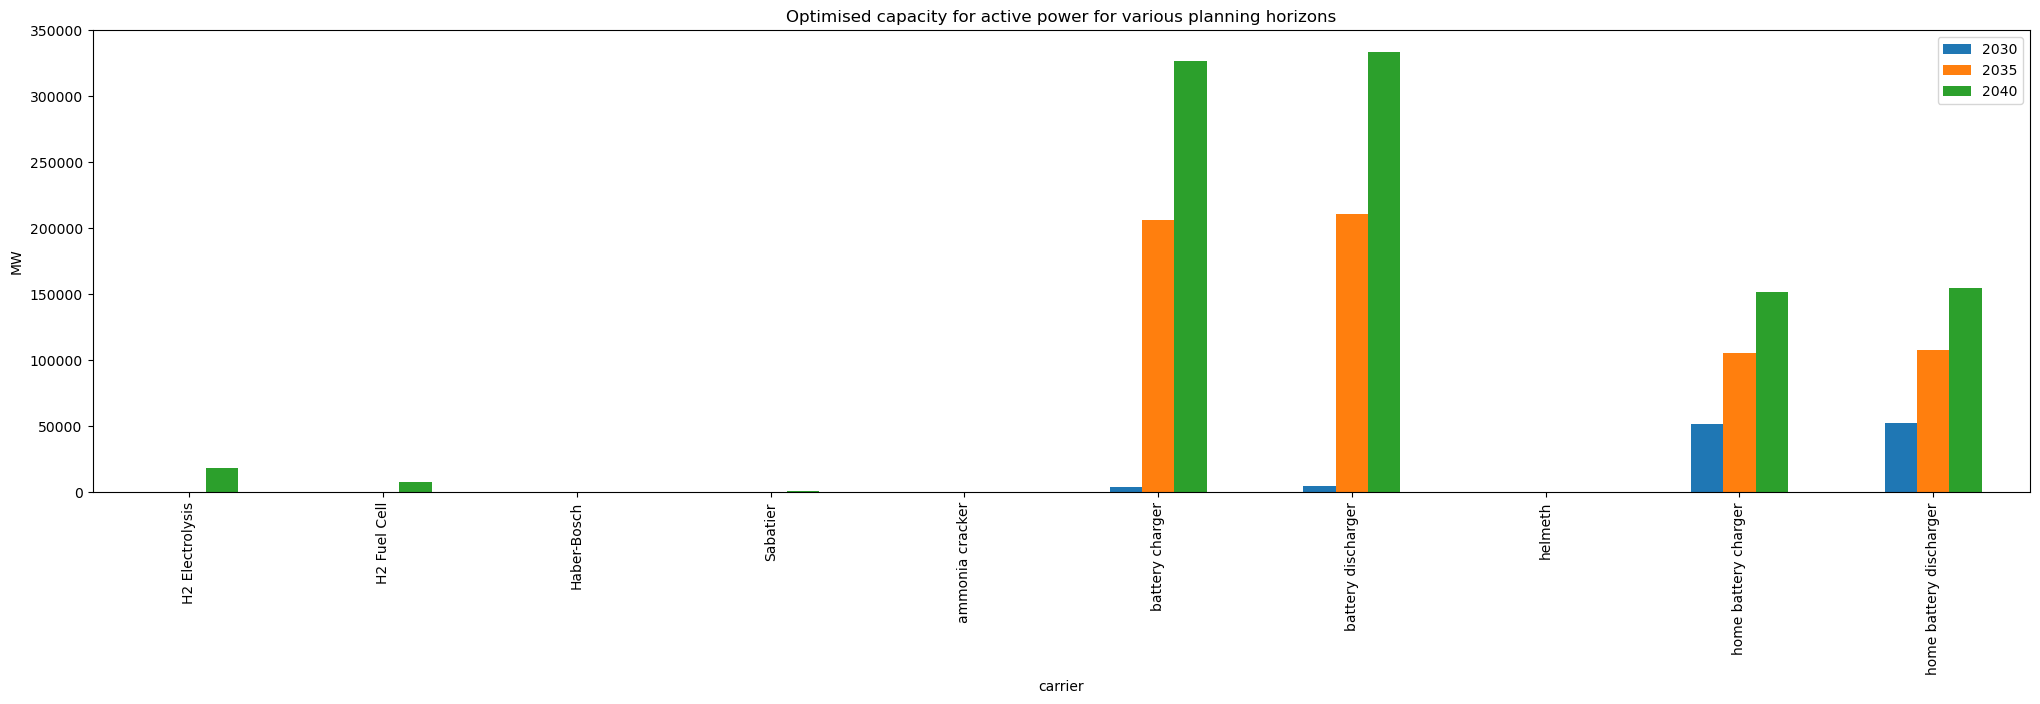

In [15]:
n_storage = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[n_y.index.isin(storage_exclude)]
    n_storage[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]] for k, ni in n_storage.items()}, kind="bar", title="Optimised capacity for active power for various planning horizons", unit="MW")